# Предсказание рейтинга отелей

## Описание проекта
Одна из проблем компании Booking — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.
Есть датасет, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.
Описание столбов в датасете:
* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [116]:
# импорт необходимых библиотек
import pandas as pd
import category_encoders as ce
from geopy.geocoders import Nominatim
import time
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Ознакомление с данными

В данном ноутбуке, чтобы потом сделать submission на Kaggle, я буду делать одинаковые преобразования над датасетом hotels (с курса Skillfactory) и над тестовым датасетом из Kaggle.

In [117]:
hotels = pd.read_csv('hotels.csv')
df_test = pd.read_csv('hotels_test.csv') # датасет для тестирования
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [118]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

17 признаков, 8 типа 'object и 9 числовых признаков. Предсказывать будем reviewer_score. Есть пропущенные значения в столбцах 'lat' и 'lng'.

Посмотрим, есть ли в наших данных дубликаты:

In [119]:
hotels_duplicates = hotels[hotels.duplicated()]
print(f'Число найденных дубликатов: {hotels_duplicates.shape[0]}')

Число найденных дубликатов: 307


Избавимся от дубликатов

In [120]:
hotels = hotels.drop_duplicates()
print(f'Результирующее число записей: {hotels.shape[0]}')

Результирующее число записей: 386496


## Ответы на вопросы юнита 4
Ответим на вопросы юнита 4. Оценку значимости признаков я планирую привести позже, после того, как переведу все категориальные признаки в числовые.

### Количество уникальных названий отелей

In [121]:
print('Количество уникальных отелей равно', hotels['hotel_name'].nunique())

Количество уникальных отелей равно 1492


### Когда оставлен самый старый и самый свежий отзыв

In [122]:
# переведем признак с датой в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
df_test['review_date'] = pd.to_datetime(df_test['review_date'])
print('Самый свежий отзыв был оставлен:', hotels['review_date'].min())
print('Самый старый отзыв был оставлен:', hotels['review_date'].max())

Самый свежий отзыв был оставлен: 2015-08-04 00:00:00
Самый старый отзыв был оставлен: 2017-08-03 00:00:00


### Количество уникальных тегов

In [123]:
# Преобразуем столбец с тегами в столбец со списоком тегов:
def tags_to_list(tag): # функция для преобразования строки с тегами в список тегов:
    tag = tag[2:-2] # уберем лишние символы в начале и конце тегов
    res = tag.strip().split(' \', \' ') # уберем пробелы с начала и конца строки, разделим на теги по символам " ', ' "
    return res
# применим функцию к столбцу с тегами
hotels['tags_new'] = hotels['tags'].apply(tags_to_list)
df_test['tags_new'] = df_test['tags'].apply(tags_to_list)
# подсчитаем уникальные тэги:
print('Количество уникальных тэгов равно', len(hotels['tags_new'].explode().unique()))

Количество уникальных тэгов равно 2368


### Наиболее часто встречающийся тег

In [124]:
print('Чаще всего встречается тег', hotels['tags_new'].explode().value_counts().index[0])

Чаще всего встречается тег Leisure trip


### На сколько ночей чаще всего останавливались путешественники
Заодно тут создадим новый признак количество ночей 'nights'

In [125]:
# функция для выявления количества ночей из тегов:
def nights_count(list):
    for i in range(0, len(list)):
        if 'Stayed' in list[i]: # если в теге встречается слово Stayed, то берем из него количество ночей, которое идет после Stayed
            return int(list[i][7:9].replace(' ',''))

hotels['nights'] = hotels['tags_new'].apply(nights_count)
df_test['nights'] = df_test['tags_new'].apply(nights_count)
print('Чаще всего путешественники останавливались на', hotels['nights'].value_counts().index[0], 'ночь')

Чаще всего путешественники останавливались на 1.0 ночь


Также проверим, есть ли в новом столбце пропуски:

In [126]:
print(hotels['nights'].isna().sum())
print(df_test['nights'].isna().sum())

146
46


146 пропусков в общем датасете и 46 в тестовом. Заполним их наиболее часто встречающимся значением - 1.

In [127]:
hotels['nights'] = hotels['nights'].fillna(value = int('1'))
df_test['nights'] = df_test['nights'].fillna(value = int('1'))

In [128]:
hotels['nights'].describe()

count    386496.000000
mean          2.360726
std           1.646303
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
Name: nights, dtype: float64

## Удаление строковых данных

### Признак 'hotel_country'.

Начнем по порядку с признака hotel_address. Из него можно найти страну отеля.

In [129]:
# Найдем страну отеля
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-1])
df_test['hotel_country'] = df_test['hotel_address'].apply(lambda x: 'United Kingdom' if x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-1])
hotels['hotel_country'].value_counts()

United Kingdom    196773
Spain              45132
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Name: hotel_country, dtype: int64

In [130]:
# преобразуем признак, закодируем его, используя однократное кодирование
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['hotel_country'])
hotels = pd.concat([hotels, type_bin], axis=1)

type_bin = encoder.transform(df_test['hotel_country'])
df_test = pd.concat([df_test, type_bin], axis=1)

Посмотрим признак "reviewer_nationality"

In [131]:
hotels['reviewer_nationality'].value_counts().head(30)

 United Kingdom               183952
 United States of America      26494
 Australia                     16216
 Ireland                       11119
 United Arab Emirates           7612
 Saudi Arabia                   6716
 Netherlands                    6598
 Switzerland                    6492
 Canada                         5977
 Germany                        5951
 France                         5524
 Israel                         4912
 Italy                          4561
 Belgium                        4525
 Turkey                         4102
 Kuwait                         3700
 Spain                          3527
 Romania                        3422
 Russia                         2951
 South Africa                   2887
 China                          2562
 Sweden                         2560
 India                          2556
 Greece                         2531
 New Zealand                    2443
 Singapore                      2309
 Hong Kong                      2260
 

In [132]:
popular_nationality = hotels['reviewer_nationality'].value_counts().nlargest(30).index

In [133]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in popular_nationality else 'other')
df_test['reviewer_nationality'] = df_test['reviewer_nationality'].apply(lambda x: x if x in popular_nationality else 'other')
hotels['reviewer_nationality'].value_counts()

 United Kingdom               183952
other                          46074
 United States of America      26494
 Australia                     16216
 Ireland                       11119
 United Arab Emirates           7612
 Saudi Arabia                   6716
 Netherlands                    6598
 Switzerland                    6492
 Canada                         5977
 Germany                        5951
 France                         5524
 Israel                         4912
 Italy                          4561
 Belgium                        4525
 Turkey                         4102
 Kuwait                         3700
 Spain                          3527
 Romania                        3422
 Russia                         2951
 South Africa                   2887
 China                          2562
 Sweden                         2560
 India                          2556
 Greece                         2531
 New Zealand                    2443
 Singapore                      2309
 

Закодируем признак национальность ревьюера с помощью двоичного кодирования, так как уникальных значений в признаке больше 15.

In [134]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

type_bin = bin_encoder.fit_transform(df_test['reviewer_nationality'])
df_test = pd.concat([df_test, type_bin], axis=1)

Рассмотрим признак "review_date". Можно создать из него новые признаки: год оставления отзыва и месяц оставления отзыва.

In [135]:
hotels['review_year'] = hotels['review_date'].dt.year
df_test['review_year'] = df_test['review_date'].dt.year
hotels['review_year'].unique()

array([2016, 2017, 2015], dtype=int64)

In [136]:
hotels['review_month'] = hotels['review_date'].dt.month
df_test['review_month'] = df_test['review_date'].dt.month
hotels['review_month'].unique()

array([ 2,  1, 10,  9,  3, 12,  5, 11,  6,  7,  4,  8], dtype=int64)

### Признак 'days_since_review' 

Представлен в нашем датасете типом object. Преобразуем его в числовой тип:

In [137]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))
df_test['days_since_review'] = df_test['days_since_review'].apply(lambda x: int(x.split()[0]))
hotels['days_since_review'].describe()

count    386496.000000
mean        354.339339
std         208.958145
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

## Очистка от пропущенных значений

Пропущенные значения у нас есть только в столбцах с координатами 'lat' и 'lng'.
Посмотрим, у скольких отелей пропущены эти значения:

In [138]:
# создадим датафрейм, где будут строки с пропущенными значениями долготы и широты.
without_coord = hotels[hotels['lat'].isnull()]
# посмотрим, сколько отелей в получившемся датафрейме
len(without_coord['hotel_name'].value_counts())

17

Всего 17 отелей с пропущенными координатами. Можно получить координаты вручную. Можно воспользоваться специальными библиотеками для получения координат по адресу, например geopy. Однако при попытке воспользоваться библиотекой оказалось, что адреса записаны некорректно. Например, "Savoyenstra e 2 16 Ottakring 1160 Vienna Austria", а на самом деле "Savoyenstrasse 2, Vienna 1160 Austria". Возможно поэтому и отсутсвуют координаты. Я решила, что адресов не так много и можно вручную заполнить все 17 координат

In [139]:
app = Nominatim(user_agent="tutorial")
# словарь адресов для получения координат. Ключи - адрес некорректный из таблицы, значения - адрес скорректированный вручную.
address_to_get_coord = {'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria':'Savoyenstrasse 2 16 Ottakring, 1160, Vienna, Austria',
                        '23 Rue Damr mont 18th arr 75018 Paris France':'23 rue Damremont 75018 Paris France',
                        'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria':'Josefstadter Strasse 10-12 A-1080 Vienna, Austria',
                        'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria':'Waehringer Strasse 12 1090 Vienna Austria',
                        '4 rue de la P pini re 8th arr 75008 Paris France':'4 rue de la Pepiniere, 75008 Paris France',
                        'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria':'Sieveringer Strasse 4 1190 Vienna Austria',
                        'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria':'Taborstrasse 8 A 02 Leopoldstadt 1020 Vienna Austria',
                        'Bail n 4 6 Eixample 08010 Barcelona Spain':'Bailen 4-6 Eixample 08010 Barcelona Spain',
                        'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria':'Grunentorgasse 30 09 Alsergrund 1090 Vienna Austria',
                        'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria':'Landstrasser Gurtel 5 03 Landstrasse 1030 Vienna Austria',
                        'Paragonstra e 1 11 Simmering 1110 Vienna Austria':'Paragonstrasse 1 11 Simmering 1110 Vienna Austria',
                        'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria':'Wahringer Strasse 33 1090 Vienna Austria',
                        '20 Rue De La Ga t 14th arr 75014 Paris France': '20 Rue De La Gaite 75014 Paris France',
                        'Hasenauerstra e 12 19 D bling 1190 Vienna Austria':'Hasenauerstrasse 12 1190 Vienna Austria',
                        'Sep lveda 180 Eixample 08011 Barcelona Spain':'Sepulveda 180 Eixample 08011 Barcelona Spain',
                        'Pau Clar s 122 Eixample 08009 Barcelona Spain':'Pau Claris 122 Eixample 08009 Barcelona Spain',
                        'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria':'Josefstadter Strasse 22 08 Josefstadt 1080 Vienna Austria'}

# словарь координат для заполнения

coordinates = {}

#Пришлось закомментить дальнейшний код, по которому я собирала словарь с координатами, так он перестал работать, 
# я не разобралась, почему. Просто в предыдущий запусках у меня сохранился выведенный словарь, использую его дальше

#for elem in address_to_get_coord:
    #try:
       # location = app.geocode(address_to_get_coord[elem]).raw
       # coordinates[elem] = ([location["lat"], location["lon"]])
  #  except GeocoderUnavailable: # на всякий случай проверяла на ошибки, мало ли адрес не пробьется
      #  print(elem)
      
    
coordinates = {'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': ['48.2159099',
  '16.2780017'],
 '23 Rue Damr mont 18th arr 75018 Paris France': ['48.8888806', '2.3331948'],
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': ['48.2106577',
  '16.3436493'],
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': ['48.216813',
  '16.3599356'],
 '4 rue de la P pini re 8th arr 75008 Paris France': ['48.875248',
  '2.3233746'],
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': ['48.250954',
  '16.325100636510385'],
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': ['48.2172136',
  '16.3808074'],
 'Bail n 4 6 Eixample 08010 Barcelona Spain': ['41.3927215', '2.1760747'],
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': ['48.2208701',
  '16.3638771'],
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': ['48.1881916',
  '16.389577'],
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': ['48.1861187',
  '16.419982'],
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': ['48.2203011',
  '16.3558834'],
 '20 Rue De La Ga t 14th arr 75014 Paris France': ['48.8399395', '2.3236754'],
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria': ['48.23357885',
  '16.3456449712213'],
 'Sep lveda 180 Eixample 08011 Barcelona Spain': ['41.3832344',
  '2.162940206993912'],
 'Pau Clar s 122 Eixample 08009 Barcelona Spain': ['41.3927154', '2.1674921'],
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': ['48.2106577',
  '16.3436493']}

In [140]:
def fill_coord(row, dict):
    if pd.isna(row.lat):
        for i in dict.keys():
           if row.hotel_address == i:
               row.lat = dict[i][0]
               row.lng = dict[i][1]    
    return row


hotels = hotels.apply(lambda row: fill_coord(row, coordinates), axis=1 )
df_test = df_test.apply(lambda row: fill_coord(row, coordinates), axis=1 )
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
tags_new                                      0
nights                                        0
hotel_country                                 0
hotel_country_United Kingdom            

## Создание новых признаков

### Признак 'distance'


Создадим признак 'distance' - расстояние от отеля до центра города

In [141]:
# создадим столбец с координатами (с широтой и долготой в одном столбце)
hotels['coord'] = list(zip(hotels['lat'],hotels['lng']))
df_test['coord'] = list(zip(df_test['lat'],df_test['lng']))

In [142]:
# список городов
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-2])
cities = list(hotels['hotel_city'].unique()) 

In [143]:
df_test['hotel_city'] = df_test['hotel_address'].apply(lambda x: x.split(' ')[-2])

In [144]:
# получим список кортежей с координатами центров городов из библиотеки geopy
coord_center = [] 

for i in cities:
        location = app.geocode(i).raw
        coord_center.append((location["lat"], location["lon"]))
        
# создадим отдельный датафрейм с координатами центров городов       
df_center = pd.DataFrame({'hotel_city':cities,
                  'coord_center':coord_center})

In [145]:
# добавим координаты центров городов в наш датасет:
hotels = hotels.merge(df_center, on = 'hotel_city', how = 'left')
df_test = df_test.merge(df_center, on = 'hotel_city', how = 'left')

In [146]:
from geopy.distance import geodesic as GD 
# функция для получения расстояния между отелем и центром города
def get_distance(row):
    hotel_coord = row.coord
    center_coord = row.coord_center
    return round(GD(hotel_coord, center_coord).km, 1) 
# применим функцию get_distance к датасету:
hotels['distance'] = hotels.apply(lambda x: get_distance(x), axis = 1)
df_test['distance'] = df_test.apply(lambda x: get_distance(x), axis = 1)

In [147]:
hotels['distance'].describe()

count    386496.000000
mean       3044.326245
std        2987.085007
min           0.000000
25%           1.900000
50%        5966.200000
75%        5977.300000
max        5989.000000
Name: distance, dtype: float64

### Признак 'ratio_words'

Создадим признак пропорции количества слов из позитивных отзывов к количеству слов в негативных отзывах. Я читер, видела в чате проекта, что количество слов подсчитано в исходном датасете не совсем верно... Поэтому перезапишу на всякий случай столбцы с количеством слов в позитивных и негативных отзывах.

In [148]:
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x: len(x.split(' ')))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x: len(x.split(' ')))

df_test['review_total_negative_word_counts'] = df_test['negative_review'].apply(lambda x: len(x.split(' ')))
df_test['review_total_positive_word_counts'] = df_test['positive_review'].apply(lambda x: len(x.split(' ')))

In [149]:
hotels['ratio_words'] = hotels['review_total_negative_word_counts'] / hotels['review_total_positive_word_counts']
df_test['ratio_words'] = df_test['review_total_negative_word_counts'] / df_test['review_total_positive_word_counts']
hotels['ratio_words'].describe()

count    386496.000000
mean          2.670820
std           6.706297
min           0.005208
25%           0.250000
50%           0.866667
75%           2.333333
max         201.000000
Name: ratio_words, dtype: float64

### Признак 'citizen'

Создадим признак, в котором будет '1', если страна ревьюера совпадает со страной отеля и '0', если нет.


In [150]:
hotels['citizen'] = hotels.apply((lambda row: 1 if row.hotel_country == row.reviewer_nationality.strip() else 0), axis = 1)
df_test['citizen'] = df_test.apply((lambda row: 1 if row.hotel_country == row.reviewer_nationality.strip() else 0), axis = 1)
hotels['citizen'].value_counts()

0    252574
1    133922
Name: citizen, dtype: int64

### Признак 'tags_count'

Создадим признак количество тегов для каждого отзыва

In [151]:
hotels['tags_count'] = hotels['tags_new'].apply(lambda x: len(x))
df_test['tags_count'] = df_test['tags_new'].apply(lambda x: len(x))
hotels['tags_count'].describe()

count    386496.000000
mean          4.569610
std           0.520157
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           6.000000
Name: tags_count, dtype: float64

### Признак 'type_trip'

Создадим признак 'type_trip', чтобы понять, была ли поездка деловой или для отдыха

In [152]:
def get_trip(x):
    if x[0] == 'Leisure trip' or x[0] == 'Business trip':
        return x[0]
    else:
        return 'unknown'
hotels['type_trip'] = hotels['tags_new'].apply(get_trip)
df_test['type_trip'] = df_test['tags_new'].apply(get_trip)
hotels['type_trip'].value_counts()

Leisure trip     312528
Business trip     61791
unknown           12177
Name: type_trip, dtype: int64

In [153]:
# преобразуем признак, закодируем его, используя однократное кодирование
encoder = ce.OneHotEncoder(cols=['type_trip'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['type_trip'])
hotels = pd.concat([hotels, type_bin], axis=1)

type_bin = encoder.fit_transform(df_test['type_trip'])
df_test = pd.concat([df_test, type_bin], axis=1)

## Преобразование признаков

Для преобразования признаков 'positive_review' и 'negative_review' используем сентиментальный анализ с помощью библиотеки NLTK.  
VADER (Valence Aware Dictionary for Sentiment Reasoning) - это модель, используемая для анализа тональности текста, которая чувствительна как к полярности (положительная / отрицательная), так и к интенсивности (силе) эмоций. Он доступен в пакете NLTK и может применяться непосредственно к немаркированным текстовым данным.

Сентиментальный анализ VADER основан на словаре, который отображает лексические характеристики на интенсивность эмоций, известную как оценка сантиментов. Оценку тональности текста можно получить, суммируя интенсивность каждого слова в тексте.
VADER’s SentimentIntensityAnalyzer() принимает строку и возвращает словарь оценок в каждой из четырех категорий:

отрицательный
нейтральный
положительный
составной (вычисляется путем нормализации приведенных выше оценок

In [154]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [155]:
hotels['scores_negative'] = hotels['negative_review'].apply(lambda negative_review: sid.polarity_scores(negative_review))
hotels['scores_positive'] = hotels['positive_review'].apply(lambda positive_review: sid.polarity_scores(positive_review))

df_test['scores_negative'] = df_test['negative_review'].apply(lambda negative_review: sid.polarity_scores(negative_review))
df_test['scores_positive'] = df_test['positive_review'].apply(lambda positive_review: sid.polarity_scores(positive_review))

In [156]:
hotels['negative_neg'] = hotels['scores_negative'].apply(lambda x: list((x).values())[0])
hotels['negative_neu'] = hotels['scores_negative'].apply(lambda x: list((x).values())[1])
hotels['negative_pos'] = hotels['scores_negative'].apply(lambda x: list((x).values())[2])
hotels['negative_compound'] = hotels['scores_negative'].apply(lambda x: list((x).values())[-1])

df_test['negative_neg'] = df_test['scores_negative'].apply(lambda x: list((x).values())[0])
df_test['negative_neu'] = df_test['scores_negative'].apply(lambda x: list((x).values())[1])
df_test['negative_pos'] = df_test['scores_negative'].apply(lambda x: list((x).values())[2])
df_test['negative_compound'] = df_test['scores_negative'].apply(lambda x: list((x).values())[-1])

In [157]:
hotels['positive_neg'] = hotels['scores_positive'].apply(lambda x: list((x).values())[0])
hotels['positive_neu'] = hotels['scores_positive'].apply(lambda x: list((x).values())[1])
hotels['positive_pos'] = hotels['scores_positive'].apply(lambda x: list((x).values())[2])
hotels['positive_compound'] = hotels['scores_positive'].apply(lambda x: list((x).values())[-1])

df_test['positive_neg'] = df_test['scores_positive'].apply(lambda x: list((x).values())[0])
df_test['positive_neu'] = df_test['scores_positive'].apply(lambda x: list((x).values())[1])
df_test['positive_pos'] = df_test['scores_positive'].apply(lambda x: list((x).values())[2])
df_test['positive_compound'] = df_test['scores_positive'].apply(lambda x: list((x).values())[-1])

## Отбор признаков

In [158]:
hotels = hotels.select_dtypes(exclude=['object'])
df_test = df_test.select_dtypes(exclude=['object'])
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386495
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                386496 non-null  int64         
 1   review_date                                 386496 non-null  datetime64[ns]
 2   average_score                               386496 non-null  float64       
 3   review_total_negative_word_counts           386496 non-null  int64         
 4   total_number_of_reviews                     386496 non-null  int64         
 5   review_total_positive_word_counts           386496 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  386496 non-null  int64         
 7   reviewer_score                              386496 non-null  float64       
 8   days_since_review                           386496 non-null  int64        

<AxesSubplot: >

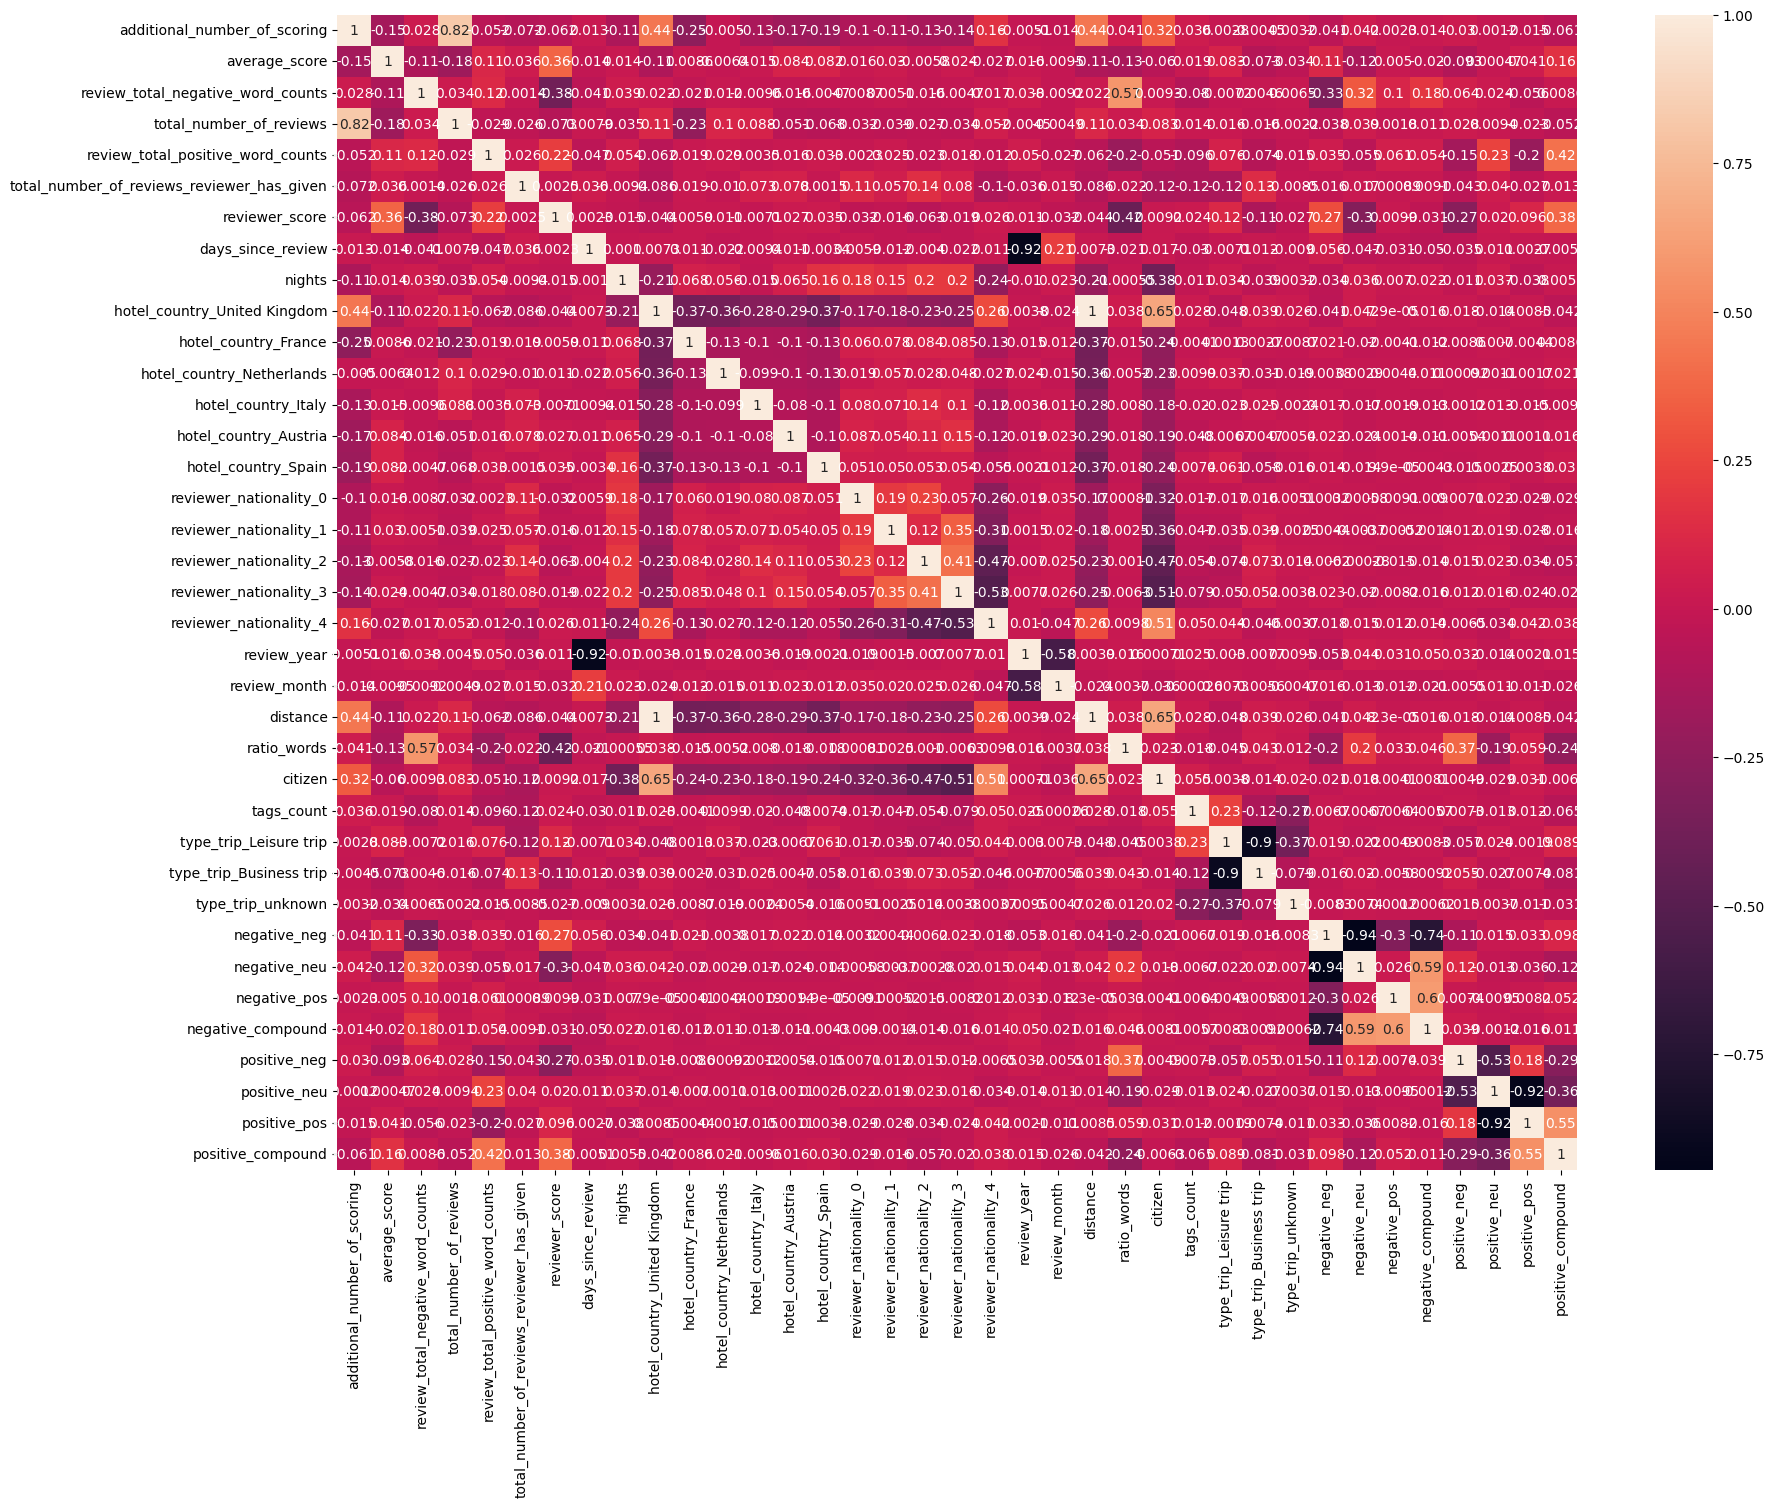

In [159]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(hotels.corr(), annot=True, fmt='.2g')

Уберем сильно коррелирующие признаки:

In [160]:
hotels.drop(['total_number_of_reviews', 'review_year', 'type_trip_Leisure trip', 'negative_neg', 'positive_pos', 'hotel_country_United Kingdom'], axis = 1, inplace=True)

In [161]:
df_test.drop(['total_number_of_reviews', 'review_year', 'type_trip_Leisure trip', 'negative_neg', 'positive_pos', 'hotel_country_United Kingdom'], axis = 1, inplace=True)

## <a id='toc1_8_'></a>[Обучение модели](#toc0_)

In [162]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
df = hotels.copy()
# df.drop(object_columns, axis = 1, inplace=True)
df.drop(['review_date'], axis = 1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386495
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386496 non-null  int64  
 1   average_score                               386496 non-null  float64
 2   review_total_negative_word_counts           386496 non-null  int64  
 3   review_total_positive_word_counts           386496 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 5   reviewer_score                              386496 non-null  float64
 6   days_since_review                           386496 non-null  int64  
 7   nights                                      386496 non-null  float64
 8   hotel_country_France                        386496 non-null  int64  
 9   hotel_country_Netherlands                   386496 non-null  int64  
 

In [163]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = df.drop(['reviewer_score'], axis = 1)  
y = df['reviewer_score'] 

In [164]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [165]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289872 entries, 116119 to 121958
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                289872 non-null  int64  
 1   average_score                               289872 non-null  float64
 2   review_total_negative_word_counts           289872 non-null  int64  
 3   review_total_positive_word_counts           289872 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  289872 non-null  int64  
 5   days_since_review                           289872 non-null  int64  
 6   nights                                      289872 non-null  float64
 7   hotel_country_France                        289872 non-null  int64  
 8   hotel_country_Netherlands                   289872 non-null  int64  
 9   hotel_country_Italy                         289872 non-null  int6

In [166]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [167]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12534205189214834


Подготовим submission для Kaggle:

In [168]:
submission = pd.read_csv('submission.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                128935 non-null  int64         
 1   review_date                                 128935 non-null  datetime64[ns]
 2   average_score                               128935 non-null  float64       
 3   review_total_negative_word_counts           128935 non-null  int64         
 4   review_total_positive_word_counts           128935 non-null  int64         
 5   total_number_of_reviews_reviewer_has_given  128935 non-null  int64         
 6   days_since_review                           128935 non-null  int64         
 7   reviewer_score                              128935 non-null  int64         
 8   nights                                      128935 non-null  float64      

In [169]:
df_test = df_test.drop(['review_date'], axis = 1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                128935 non-null  int64  
 1   average_score                               128935 non-null  float64
 2   review_total_negative_word_counts           128935 non-null  int64  
 3   review_total_positive_word_counts           128935 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  128935 non-null  int64  
 5   days_since_review                           128935 non-null  int64  
 6   reviewer_score                              128935 non-null  int64  
 7   nights                                      128935 non-null  float64
 8   hotel_country_France                        128935 non-null  int64  
 9   hotel_country_Netherlands                   128935 non-null  int64  
 

In [170]:
submission.shape

(128935, 2)

In [171]:
df_test = df_test.drop(['reviewer_score'], axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                128935 non-null  int64  
 1   average_score                               128935 non-null  float64
 2   review_total_negative_word_counts           128935 non-null  int64  
 3   review_total_positive_word_counts           128935 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  128935 non-null  int64  
 5   days_since_review                           128935 non-null  int64  
 6   nights                                      128935 non-null  float64
 7   hotel_country_France                        128935 non-null  int64  
 8   hotel_country_Netherlands                   128935 non-null  int64  
 9   hotel_country_Italy                         128935 non-null  int64  
 

In [172]:
predict_submission = regr.predict(df_test)
submission['reviewer_score'] = predict_submission
submission.to_csv('submission_predict_df_test.csv', index=False)
